<a href="https://colab.research.google.com/github/86lekwenshiung/Graph-Network-for-Fraud-Analysis/blob/main/Network_Analysis_on_Enron_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Import Libraries
___

In [3]:
# General Utility
import os
import email
import datetime

import pandas as pd
import numpy as np
import random
import re
from itertools import chain

pd.set_option('display.max_column' , None)
pd.set_option('display.max_rows',20)

# Network and Graph Related
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style('white')



# !pip install igraph

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 0.5 General Function
___

In [5]:
def random_sentence_reader(df , col):
  sample_sentence = random.choice(df[col])

  return sample_sentence

In [6]:
import re
def split_text(text, match):	
    text = re.sub(r"\n\t", "", text)
    return re.split(match, text)

#=== create a function to extract proper text from the email body
def extract_body(text, substr):	
    result = re.split(substr, text)[-1]
    result = re.sub(r"([\n-])", "", result)
    return result

#=== clean up the data fields
#- function to extract email addresses
def extract_emails(text, substr):
    result = re.findall("[^\s]+@[\w]+.[\w]+", str(text))
    if substr not in text:
        result = ""
    return result

#- function to extract subject
def extract_subject(text):

    list_of_words = re.split("\s", text)
    words_to_drop = ["Subject:","re:","Re:","RE:","fw:","Fw:", "FW:"]

    desired_words = []
    for word in list_of_words:
        if word not in words_to_drop:
            desired_words.append(word)

    r = re.compile("[\w]{3,}")
    final_list = list(filter(r.match, desired_words))

    return final_list 

#- function to extract the name of entity
def extract_entity(text):	
    string = ""
    for i in text:
        string = string + " " + i

    list_of_emails = list(re.findall(r"@[\w]+", string))	
    result = []
    for item in list_of_emails:		
        result.append(item[1:])

    return set(result)

# 1.0 EDA on Enron Dataset
___

### 1.1 Cleaning Up Dataset Part 1
___

In [ ]:
enron_email_path  = '/content/gdrive/MyDrive/Graph Network for Fraud Analysis/data/emails.csv'

df_email = pd.read_csv(enron_email_path)

In [ ]:
df_email.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [ ]:
# print(df_email['message'].loc[517040])

### 1.2 Reading Sample Raw Message
___
- Credit and Source from https://www.kaggle.com/keeperboy/enron-email-analysis-link-analysis for the cleaning up in this section 1.2

In [ ]:
# Sample Enron Email
sample_message = random.choice(df_email['message'])
sample_message

'Message-ID: <31309261.1075853728941.JavaMail.evans@thyme>\nDate: Fri, 17 Mar 2000 06:53:00 -0800 (PST)\nFrom: scott.goodell@enron.com\nTo: chris.germany@enron.com, dkinney@columbiaenergygroup.com\nSubject: CNG Recalls for Columbia\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Scott Goodell\nX-To: Chris Germany, dkinney@columbiaenergygroup.com\nX-cc: \nX-bcc: \nX-Folder: \\Chris_Germany_Dec2000\\Notes Folders\\Ces\nX-Origin: Germany-C\nX-FileName: cgerman.nsf\n\nChris and Doug - Do you know why this is being recalled?\nScott\n---------------------- Forwarded by Scott Goodell/Corp/Enron on 03/17/2000 \n02:53 PM ---------------------------\n\n\n"LoConte, Jeff" <JLoConte@bostongas.com> on 03/17/2000 02:41:25 PM\nTo: "\'- Scott Goodell Columbia\'" <scott.goodell@enron.com>, "\'- Terri Cooper \nCNG\'" <terri_g._cooper@cngt.cng.com>\ncc:  \n\nSubject: CNG Recalls for Columbia\n\n\nScott,\nPlease forward to Terri Cooper ASAP.\nThanks\

In [ ]:
# Sample Enrol Email Split by newline
sample_message_split = sample_message.split('\n')
sample_message_split

['Message-ID: <31309261.1075853728941.JavaMail.evans@thyme>',
 'Date: Fri, 17 Mar 2000 06:53:00 -0800 (PST)',
 'From: scott.goodell@enron.com',
 'To: chris.germany@enron.com, dkinney@columbiaenergygroup.com',
 'Subject: CNG Recalls for Columbia',
 'Mime-Version: 1.0',
 'Content-Type: text/plain; charset=us-ascii',
 'Content-Transfer-Encoding: 7bit',
 'X-From: Scott Goodell',
 'X-To: Chris Germany, dkinney@columbiaenergygroup.com',
 'X-cc: ',
 'X-bcc: ',
 'X-Folder: \\Chris_Germany_Dec2000\\Notes Folders\\Ces',
 'X-Origin: Germany-C',
 'X-FileName: cgerman.nsf',
 '',
 'Chris and Doug - Do you know why this is being recalled?',
 'Scott',
 '---------------------- Forwarded by Scott Goodell/Corp/Enron on 03/17/2000 ',
 '02:53 PM ---------------------------',
 '',
 '',
 '"LoConte, Jeff" <JLoConte@bostongas.com> on 03/17/2000 02:41:25 PM',
 'To: "\'- Scott Goodell Columbia\'" <scott.goodell@enron.com>, "\'- Terri Cooper ',
 'CNG\'" <terri_g._cooper@cngt.cng.com>',
 'cc:  ',
 '',
 'Subject: C

In [ ]:
print('Sample Date Extract: ' , sample_message.split('\n')[1])
print('Sample Sender: ' , sample_message.split('\n')[2])
print('Sample Receipant: ' , sample_message.split('\n')[3])
print('Sample Subject: ' , sample_message.split('\n')[4])
print('Sample cc: ' , sample_message.split('\n')[5])
print('Sample bcc: ' , sample_message.split('\n')[9])

Sample Date Extract:  Date: Fri, 17 Mar 2000 06:53:00 -0800 (PST)
Sample Sender:  From: scott.goodell@enron.com
Sample Receipant:  To: chris.germany@enron.com, dkinney@columbiaenergygroup.com
Sample Subject:  Subject: CNG Recalls for Columbia
Sample cc:  Mime-Version: 1.0
Sample bcc:  X-To: Chris Germany, dkinney@columbiaenergygroup.com


In [ ]:
# Using Email library

x = df_email.loc[10000]['message']
email.message_from_string(x).items()

[('Message-ID', '<7929445.1075854731596.JavaMail.evans@thyme>'),
 ('Date', 'Fri, 21 Jan 2000 09:15:00 -0800 (PST)'),
 ('From', 'eric.bass@enron.com'),
 ('To', 'kyle.lilly@enron.com'),
 ('Subject', 'New Model'),
 ('Cc', 'joanie.ngo@enron.com'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=us-ascii'),
 ('Content-Transfer-Encoding', '7bit'),
 ('Bcc', 'joanie.ngo@enron.com'),
 ('X-From', 'Eric Bass'),
 ('X-To', 'Kyle R Lilly'),
 ('X-cc', 'Joanie H Ngo'),
 ('X-bcc', ''),
 ('X-Folder', "\\Eric_Bass_Dec2000\\Notes Folders\\'sent mail"),
 ('X-Origin', 'Bass-E'),
 ('X-FileName', 'ebass.nsf')]

In [ ]:
# 1st round of Extraction
df_email['date'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('Date')) email.message_from_string(message)
df_email['subject'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('Subject'))
df_email['sender_email'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('From'))
df_email['recipient_email'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('To'))
df_email['cc'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('Cc'))
df_email['bcc'] = df_email['message'].apply(lambda x: email.message_from_string(x).get('Bcc'))
df_email["body"] = df_email['message'].apply(lambda x: email.message_from_string(x).get_payload())

# 2nd Round of Extraction
df_email['date'] = pd.to_datetime(df_email['date'] , utc = True)
df_email["day_of_week"] = df_email['date'].dt.day_name()
df_email['date'] = df_email['date'].dt.strftime('%Y-%m-%d')

In [ ]:
print('email DF after cleaned :' , df_email.shape)
df_email.head()

email DF after cleaned : (517401, 10)


,file,message,date,subject,sender_email,recipient_email,cc,bcc,body,day_of_week
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,2001-05-14,,phillip.allen@enron.com,tim.belden@enron.com,None,None,Here is our forecast\n\n,Monday
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,2001-05-04,Re:,phillip.allen@enron.com,john.lavorato@enron.com,None,None,Traveling to have a business meeting takes the...,Friday
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,2000-10-18,Re: test,phillip.allen@enron.com,leah.arsdall@enron.com,None,None,test successful. way to go!!!,Wednesday
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,2000-10-23,,phillip.allen@enron.com,randall.gay@enron.com,None,None,"Randy,\n\n Can you send me a schedule of the s...",Monday
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,2000-08-31,Re: Hello,phillip.allen@enron.com,greg.piper@enron.com,None,None,Let's shoot for Tuesday at 11:45.,Thursday


In [ ]:
#Exporting to Google Drive
enron_email_path  = '/content/gdrive/MyDrive/Graph Network for Fraud Analysis/data/emails_cleaned.csv'

df_email.to_csv(enron_email_path)

### 1.2.5 Cleaning Up Dataset Part 2
___

In [7]:
# Clean Up Round #2
enron_email_path  = '/content/gdrive/MyDrive/Graph Network for Fraud Analysis/data/emails_cleaned.csv'

df_email = pd.read_csv(enron_email_path , parse_dates = ['date'])

In [8]:
df_email.fillna('' , inplace = True)

# Removing Email that has no recipant
print('Before Excluding no Recipient' , df_email.shape)
df_email = df_email[df_email['recipient_email'] != '']
print('After Excluding no Recipient' , df_email.shape)

# Combining Total Recipiants
df_email['recipient_email'] = df_email['recipient_email'].apply(lambda x : x.replace('\n\t' , ''))
df_email['cc'] = df_email['cc'].apply(lambda x : x.replace('\n\t' , ''))
df_email['bcc'] = df_email['bcc'].apply(lambda x : x.replace('\n\t' , ''))

df_email["all_recipient_emails"] = df_email[['recipient_email' , 'cc' , 'bcc']].apply(pd.unique,1).apply(','.join).str.rstrip(',')
df_email["num_recipient"] = df_email['all_recipient_emails'].apply(lambda x : len(x.split(',')))

Before Excluding no Recipient (517401, 11)
After Excluding no Recipient (495554, 11)


In [9]:
# Filtering Email from 1985 to 2002
df_email["year"] = df_email['date'].dt.year

print('Before Excluding Out of Range Year' , df_email.shape)
df_email = df_email[(df_email['year'] >1984) & (df_email['year'] <2003)]
print('After Excluding Out of Range Year' , df_email.shape)


Before Excluding Out of Range Year (495554, 14)
After Excluding Out of Range Year (495160, 14)


In [6]:
df_email.head()

,Unnamed: 0,file,message,date,subject,sender_email,recipient_email,cc,bcc,body,day_of_week,all_recipient_emails,num_recipient,year
0,0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,2001-05-14,,phillip.allen@enron.com,tim.belden@enron.com,,,Here is our forecast\n\n,Monday,tim.belden@enron.com,1,2001
1,1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,2001-05-04,Re:,phillip.allen@enron.com,john.lavorato@enron.com,,,Traveling to have a business meeting takes the...,Friday,john.lavorato@enron.com,1,2001
2,2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,2000-10-18,Re: test,phillip.allen@enron.com,leah.arsdall@enron.com,,,test successful. way to go!!!,Wednesday,leah.arsdall@enron.com,1,2000
3,3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,2000-10-23,,phillip.allen@enron.com,randall.gay@enron.com,,,"Randy,\n\n Can you send me a schedule of the s...",Monday,randall.gay@enron.com,1,2000
4,4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,2000-08-31,Re: Hello,phillip.allen@enron.com,greg.piper@enron.com,,,Let's shoot for Tuesday at 11:45.,Thursday,greg.piper@enron.com,1,2000


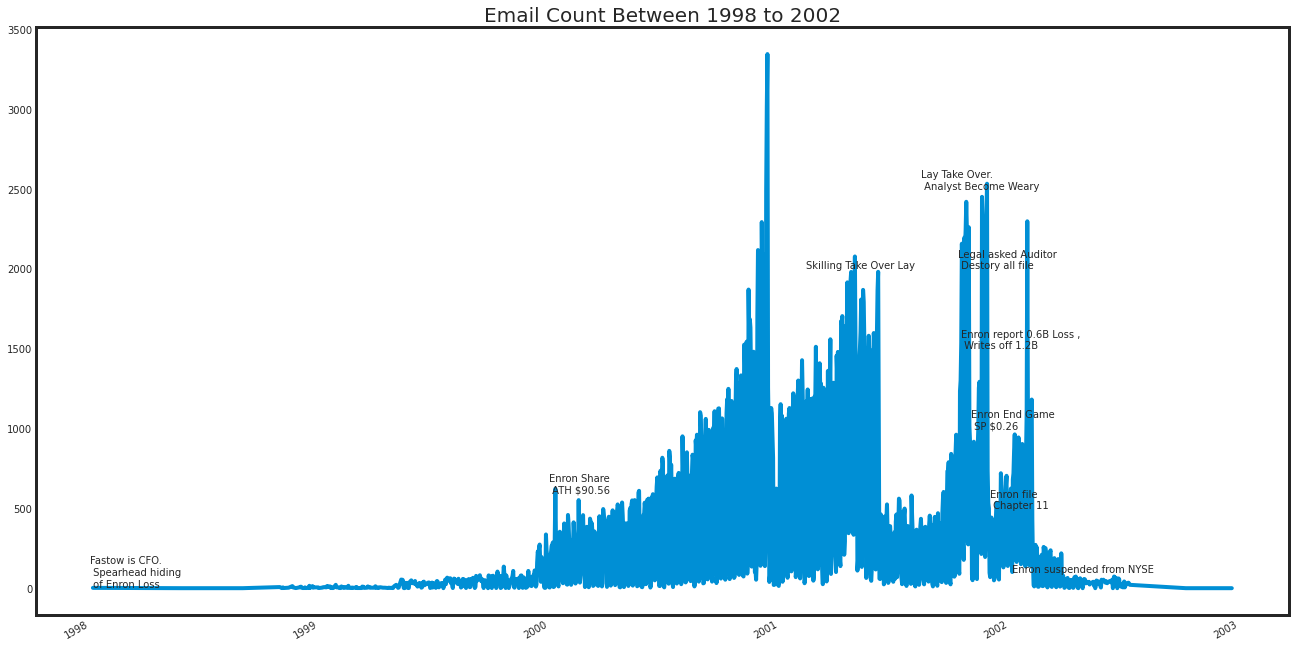

In [7]:
df_email['date'].value_counts().sort_index()[4:].plot(kind = 'line' , figsize = (20,12));

plt.title('Email Count Between 1998 to 2002' , fontsize = 20)

plt.text(x = '1998-01-01' , y = 10, s = 'Fastow is CFO. \n Spearhead hiding \n of Enron Loss')

plt.text(x = '2000-01-01' , y = 600, s = 'Enron Share \n ATH $90.56');
plt.text(x = '2001-02-12' , y = 2000, s = 'Skilling Take Over Lay');
plt.text(x = '2001-08-14' , y = 2500, s = 'Lay Take Over. \n Analyst Become Weary');
plt.text(x = '2001-10-12' , y = 2000, s = 'Legal asked Auditor \n Destory all file');
plt.text(x = '2001-10-16' , y = 1500, s = 'Enron report 0.6B Loss , \n Writes off 1.2B');
plt.text(x = '2001-11-01' , y = 1000, s = 'Enron End Game \n SP $0.26');
plt.text(x = '2001-12-02' , y = 500, s = 'Enron file \n Chapter 11');
plt.text(x = '2002-01-05' , y = 100, s = 'Enron suspended from NYSE');

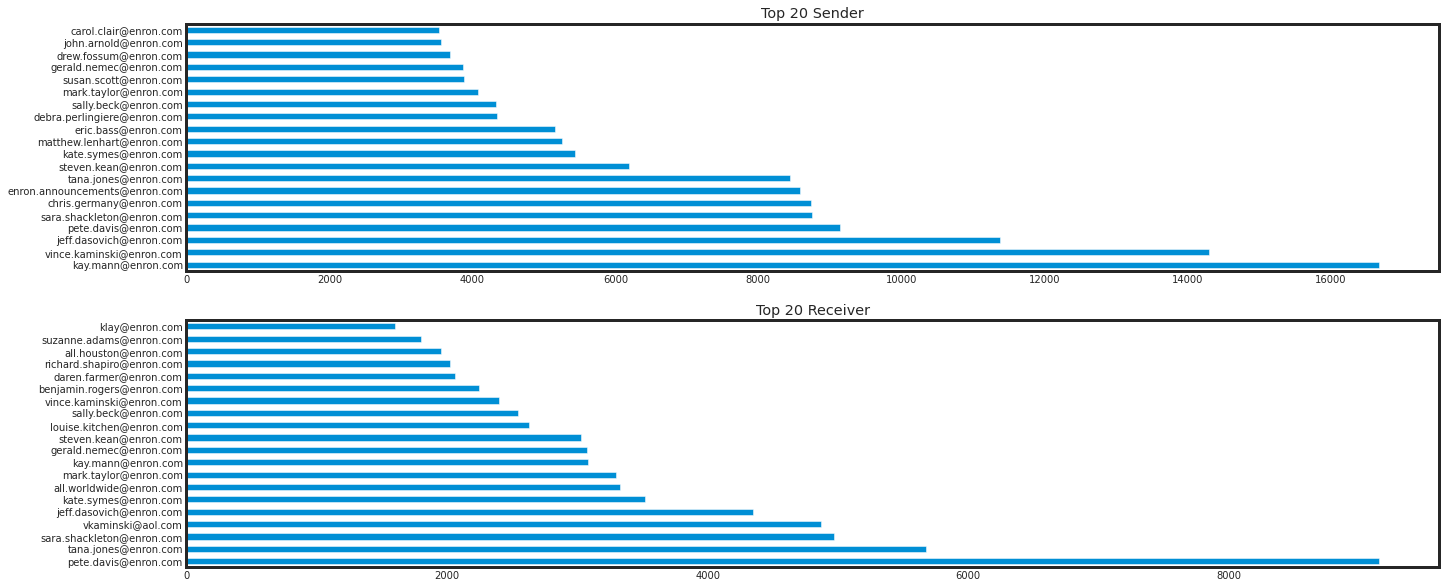

In [34]:
fig , axes = plt.subplots(2,1,figsize = (20,10))

df_email['sender_email'].value_counts()[:20].plot(kind = 'barh' , ax = axes[0])
df_email['recipient_email'].value_counts()[:20].plot(kind = 'barh' , ax = axes[1]);

axes[0].set_title('Top 20 Sender')
axes[1].set_title('Top 20 Receiver');

In [10]:
def extract_entity(text):	

    list_of_emails = re.findall(r"@[\w]+", text)
    result = []
    for item in list_of_emails:		
        result.append(item[1:])

    return set(result)

In [11]:
#- extract sender and recipient entity info
df_email["sender_entity"]    = df_email.loc[:,"sender_email"].apply(lambda x : extract_entity(x))
df_email["recipient_entity_to"] = df_email.loc[:,"recipient_email"].apply(lambda x : extract_entity(x))
df_email["recipient_entity_cc"] = df_email.loc[:,"cc" ].apply(lambda x : extract_entity(x))
df_email["recipient_entity_bcc"] = df_email.loc[:,"bcc"].apply(lambda x : extract_entity(x))
df_email["all_recipient_entities"] = df_email.apply(lambda x : \
                                                 x["recipient_entity_to" ] | \
                                                 x["recipient_entity_cc" ] | \
                                                 x["recipient_entity_bcc"], axis = 1)

df_email["sender_entity"] = df_email.sender_entity.apply(lambda x : list(x))
df_email["all_recipient_entities"] = df_email.all_recipient_entities.apply(lambda x : list(x))

# #- extract subject
# df_email.loc[:,"subject"] = df_email.loc[:,"subject"].apply(lambda x : extract_subject(x))

#=== select and reorder the colums
df = df_email.loc[:,["date","day_of_week","subject","body","sender_email","all_recipient_emails",
                                 "sender_entity","all_recipient_entities","num_recipient"]]  

df.reset_index(inplace = True)

In [20]:
print('df_email shape :' , df_email.shape)
print('df shape :' , df.shape)
df.loc[202205 : 202208]

df_email shape : (495160, 19)
df shape : (495160, 10)


,index,date,day_of_week,subject,body,sender_email,all_recipient_emails,sender_entity,all_recipient_entities,num_recipient
202205,210535,2001-04-11,Wednesday,Re: CHARM,"Jim,\n\nCHARM looks more like a prototype tha...",vince.kaminski@enron.com,"james.bouillion@enron.com,vince.kaminski@enron...",[enron],[enron],3
202206,210536,2000-11-06,Monday,Re: Avistar Training,I will keep you informed !\n------------------...,kevin.moore@enron.com,"vince.kaminski@enron.com, mike.roberts@enron.c...",[enron],[enron],4
202207,210537,2000-11-06,Monday,Re: Meeting Tuesday,"Dale,\n\nYour memory did not fail you.\nWe wou...",vince.kaminski@enron.com,"dale.nesbitt@worldnet.att.net,vince.kaminski@e...",[enron],"[worldnet, enron]",2
202208,210538,2000-11-03,Friday,Confirmation of your order,This is an automatic confirmation of the order...,messaging.agent@enron.com,"leann.walton@enron.com,vince.kaminski@enron.com",[enron],[enron],2


### 1.3 Unpacking Sender and Receipant
___

In [72]:
def unpack_str(df_col1, df_col2):
    result_df = pd.DataFrame({ "send" : np.repeat(df_col1.values, df_col2.str.count(',') + 1),
                               "receive": list(chain.from_iterable(df_col2.str.split(',')))})
    return result_df

def unpack_list(df_col1, df_col2):
    result_df = pd.DataFrame({ "send" : np.repeat(df_col1.values, df_col2.str.len()),
                               "receive": list(chain.from_iterable(df_col2))})
    return result_df      

In [81]:
df2a = unpack_str(df['sender_email'], df['all_recipient_emails'])
df2b = unpack_list(df['sender_entity'], df['all_recipient_entities'])

# df2b_senderlist = df2b['send'][:400000].apply(lambda x : x[0]).to_list().extend(df2b['send'][400000 : df2b.shape[0]].apply(lambda x : x[0]).to_list())

print('df2a :' , df2a.shape)
print('df2b :' , df2b.shape)

df2a : (3685225, 2)
df2b : (762200, 2)


### 1.4 Going in depth on the dataset
___

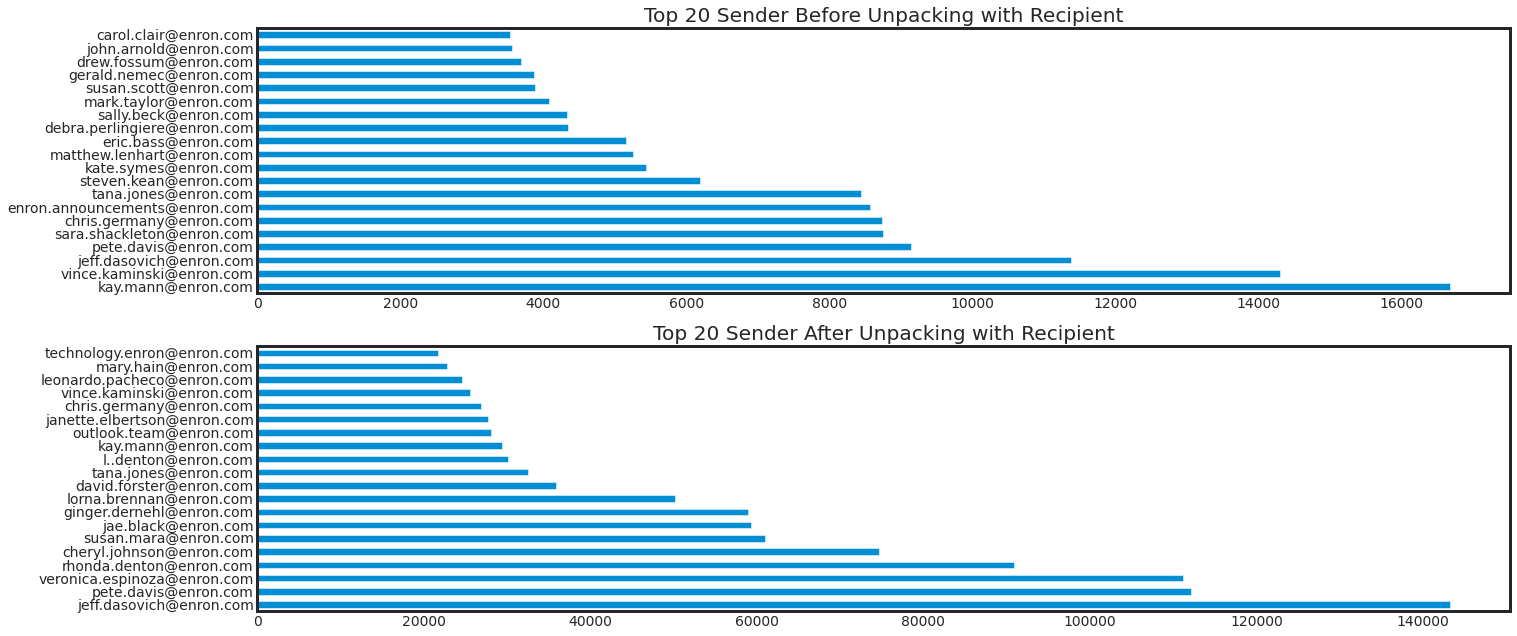

In [26]:
fig , axes = plt.subplots(2,1,figsize = (20,10))

df_email['sender_email'].value_counts()[:20].plot(kind = 'barh' , ax = axes[0])
df2a['send'].value_counts()[:20].plot(kind = 'barh' , ax = axes[1]);

axes[0].set_title('Top 20 Sender Before Unpacking with Recipient')
axes[1].set_title('Top 20 Sender After Unpacking with Recipient');

# 2.0 Network Analysis Using Networkx Library
___

| Type of Centrality 	| Description 	|
|---	|---	|
| Degree Centrality 	| It’s the most intuitive notion of centrality. Node with the highest degree is the most important. <br>It gives the index of exposure to what is flowing in the network. Central actor is most likely to hear a gossip 	|
| Betweenness Centrality 	| Betweenness centrality of a node ‘u’ is the ratio of the shortest paths between all other nodes that pass through u. 	|
| Eigenvector Centrality 	| It’s the measure of influence of a node in a network. Connections to high scoring nodes contribute more. <br>“An important node is connected to important neighbor” which means a node has high score if connected to many nodes are themselves well connected. <br>Power iteration is one of the eigenvector algorithm 	|
| Closeness Centrality 	| A node is considered important if it is relatively close to all other nodes. <br>It’s a measure of how long it will take to spread info from node 'u' to all other nodes 	|

### 2.1 Degree Centrality
___

In [27]:
#=== for the sender and recipient emails
#- define the graph
G1 = nx.from_pandas_edgelist(df2a, "send", "receive")
print('No. of Nodes : ' , G1.number_of_nodes())

No. of Nodes :  100164


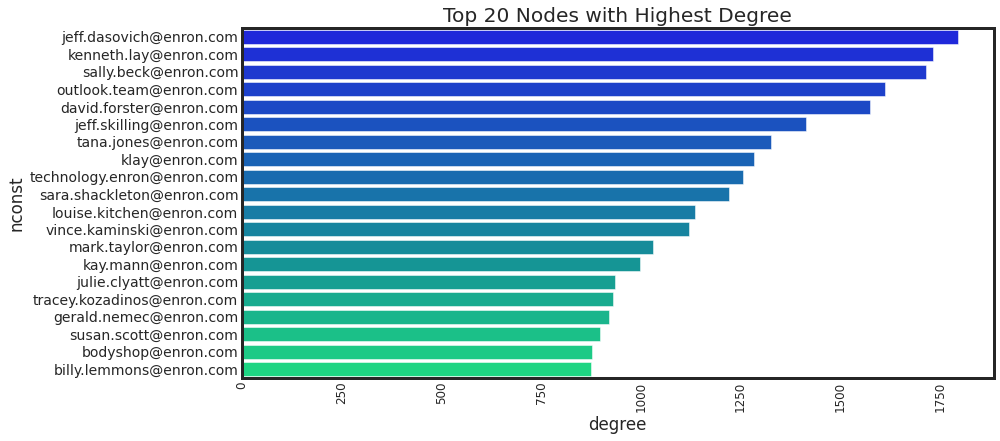

In [45]:
G1_degree = pd.DataFrame(sorted(G1.degree, key=lambda x: x[1], reverse=True))
G1_degree.columns = ['nconst','degree']

plt.figure(figsize = (12,6))
sns.barplot(y = 'nconst',
            x = 'degree',
            data = G1_degree[:20],
            palette = 'winter')
plt.xticks(rotation = 90 , fontsize = 12)
plt.title('Top 20 Nodes with Highest Degree');

In [82]:
# G2 = nx.from_pandas_edgelist(df2b, "send", "receive")

# #- we define the closeness measure
# closeness_G2 = nx.closeness_centrality(G2)
# closeness_G2 = list(closeness_G2.values())

# #- plot the network
# plt.figure(figsize = (20,20))
# pos2 = nx.spring_layout(G2, k=.1)
# nx.draw(G2, pos2, node_size = 300, node_color = closeness_G2,with_labels = True)
# plt.show()